# 8-queens


In [2]:
# Execute "pip install qiskit_ibm_runtime" on terminal (qiskit environment)
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator, Aer
from qiskit.circuit.library import UGate
from numpy import pi, random
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

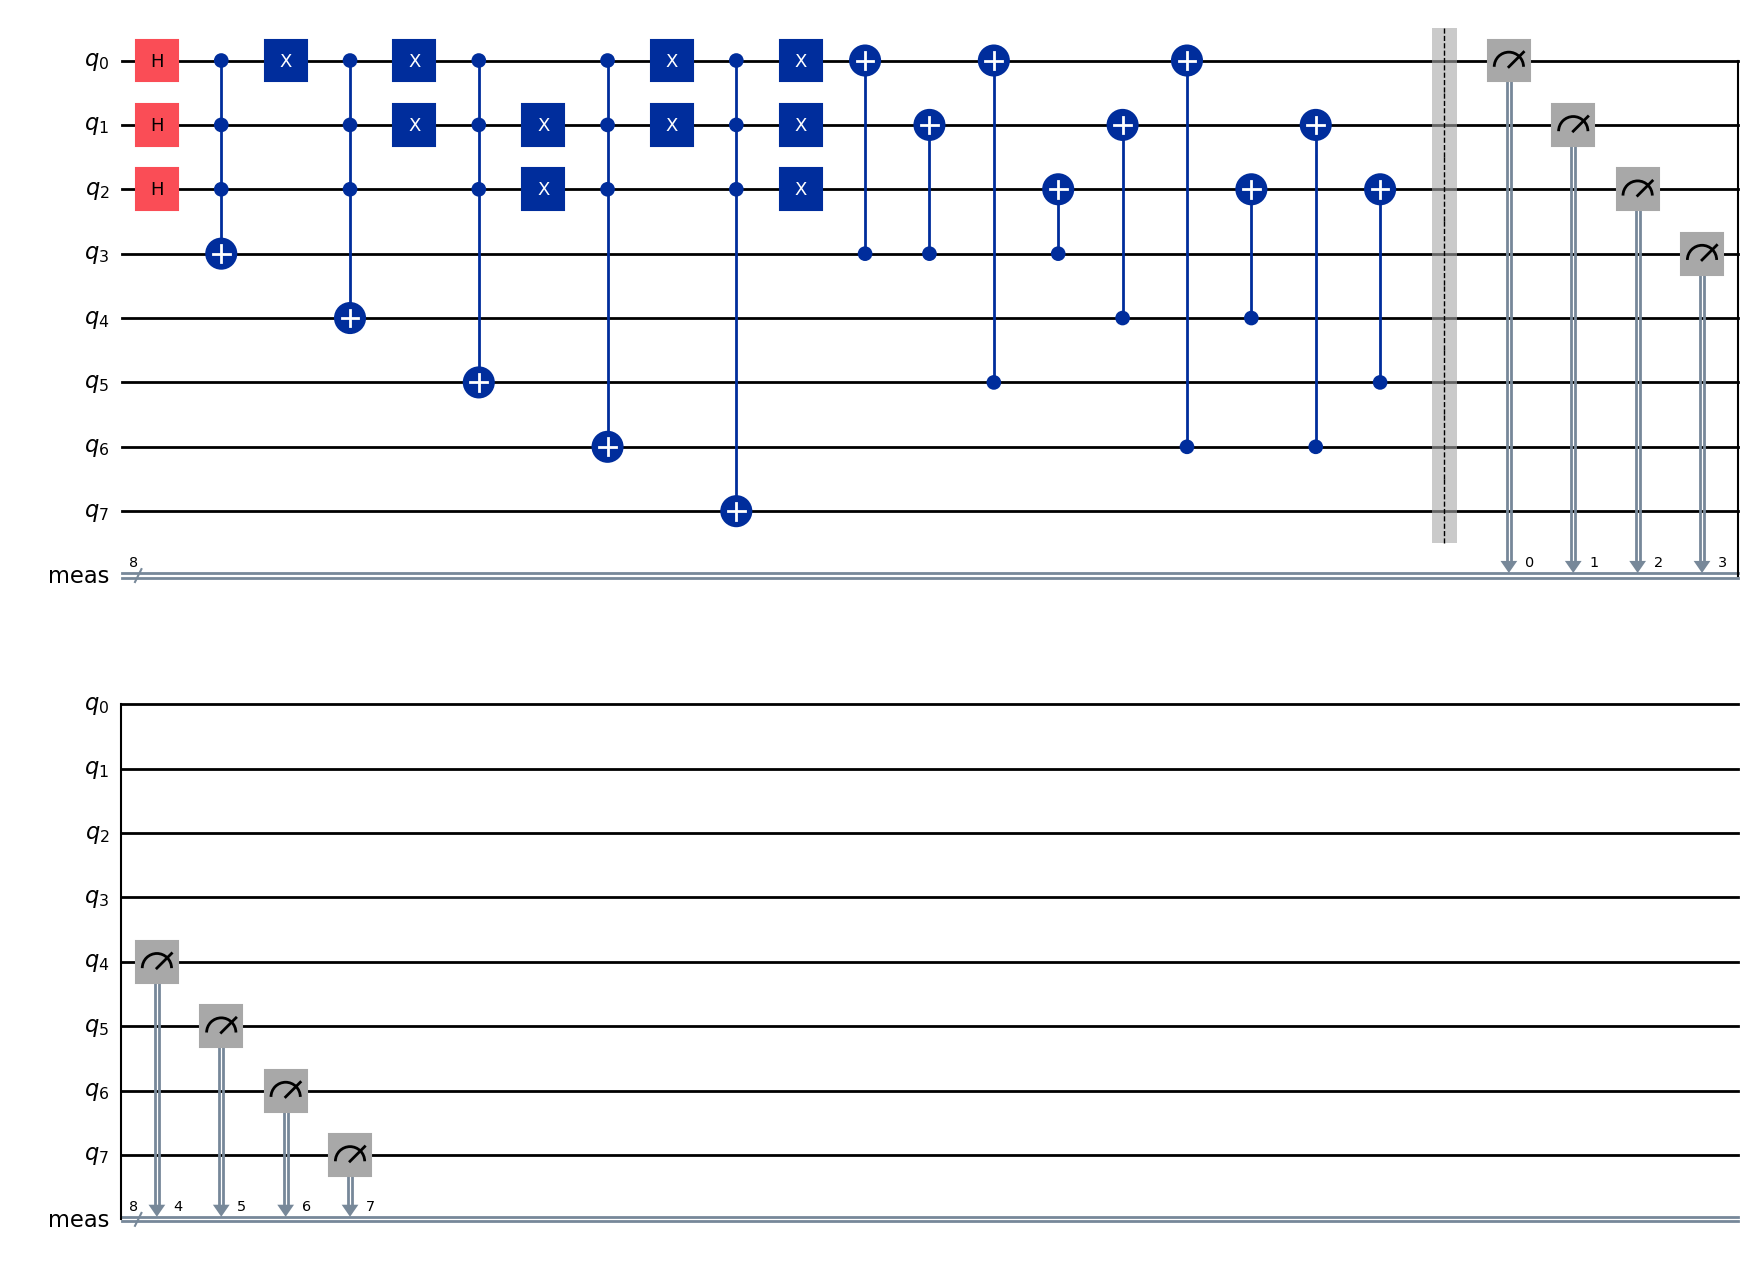

In [21]:
rc = QuantumCircuit(8)

# having 3 bits in superposition, 
# cause we need 2pow3 vectors to represent 
# all possible valid row position of queen
rc.h(0)
rc.h(1)
rc.h(2)

hbits = [0, 1, 2]
rc.mcx(hbits, 3)

rc.x(0)

rc.mcx(hbits, 4)

rc.x(0)
rc.x(1)

rc.mcx(hbits, 5)

rc.x(1)
rc.x(2)

rc.mcx(hbits, 6)

rc.x(0)
rc.x(1)

rc.mcx(hbits, 7)

rc.x(0)
rc.x(1)
rc.x(2)

rc.cx(3, 0)
rc.cx(3, 1)
rc.cx(3, 2)
# rc.barrier()

rc.cx(4, 1)
rc.cx(4, 2)
# rc.barrier()

rc.cx(5, 0)
rc.cx(5, 2)
# rc.barrier()

rc.cx(6, 0)
rc.cx(6, 1)
row = rc.to_instruction()

rc.measure_all()

rc.draw(output="mpl")

00100000 :  127
10000000 :  130
00001000 :  120
01000000 :  115
00000010 :  130
00000001 :  130
00010000 :  134
00000100 :  138


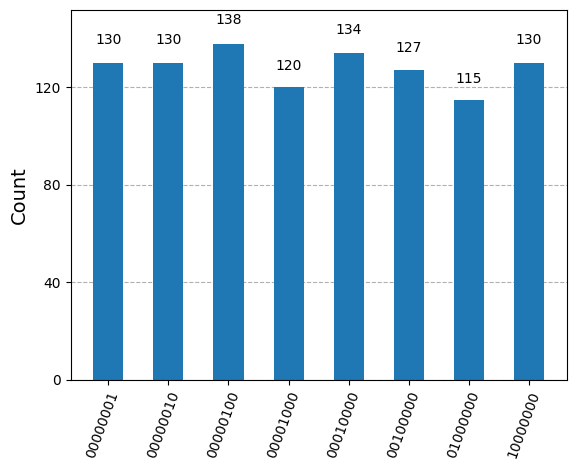

In [10]:
simulator = AerSimulator(method="statevector", device="GPU")

rc.save_statevector()

result = simulator.run(rc).result()
sv = result.get_statevector()
counts = result.get_counts(rc)
for key, value in counts.items():
    print(key, ': ', value)
plot_histogram(counts)

In [11]:
n = 8
total_qubits = (n*n)+(n-1)+(n*(n-1)/2)

qc = QuantumCircuit(total_qubits)
# 8x8 64 qubits representing 64 position in the board
# built with row gate(rgate), so each row has only one qubit excited (repesenting queen)
for i in range(0, n*n, n):
    qc.append(row, [i for i in range(i, i+n)])

qc = qc.decompose()

In [12]:
# n-1(here, 7) ancillas for column check
for i in range(n*n, (n*n)+n-1):
    qc.h(i)

for i in range(0, n*n, n):
    count = i
    for j in range(n*n, (n*n)+n-1):
        qc.cz(j, count)
        count += 1
    
for i in range(n*n, (n*n)+n-1):
    qc.h(i)
# qc.barrier()

In [13]:
for i in range((n*n)+n-1, 99):
    qc.x(i)

In [14]:
current = (n*n) + n -1
for i in range(0, n):
    for j in range(0, n):
        # right diagonal
        r,c = i+1, j+1
        while r<8 and c<8:
            qc.ccx((i*n)+j,(r*n)+c, current+r-1)
            # print((i*n)+j,(r*n)+c, current+r-1)
            r+=1
            c+=1
        #left diagonal
        r, c = i+1, j-1
        while r<8 and c>=0:
            qc.ccx((i*n)+j,(r*n)+c, current+r-1)
            # print((i*n)+j,(r*n)+c, current+r-1)
            r+=1
            c-=1
        # qc.barrier()
    current += 7-i-1

qc.measure_all()

In [15]:
qc.draw(output='text')#, filename="8queens_circuit.png")


┌───┐     ┌───┐     ┌───┐               ┌───┐     ┌───┐┌───┐     ┌───┐»
    q_0: ┤ H ├──■──┤ X ├──■──┤ X ├──■─────────■──┤ X ├──■──┤ X ├┤ X ├─────┤ X ├»
         ├───┤  │  └───┘  │  ├───┤  │  ┌───┐  │  ├───┤  │  ├───┤└─┬─┘┌───┐└─┬─┘»
    q_1: ┤ H ├──■─────────■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──┼──┤ X ├──┼──»
         ├───┤  │         │  └───┘  │  ├───┤  │  └───┘  │  ├───┤  │  └─┬─┘  │  »
    q_2: ┤ H ├──■─────────■─────────■──┤ X ├──■─────────■──┤ X ├──┼────┼────┼──»
         └───┘┌─┴─┐       │         │  └───┘  │         │  └───┘  │    │    │  »
    q_3: ─────┤ X ├───────┼─────────┼─────────┼─────────┼─────────■────■────┼──»
              └───┘     ┌─┴─┐       │         │         │                   │  »
    q_4: ───────────────┤ X ├───────┼─────────┼─────────┼───────────────────┼──»
                        └───┘     ┌─┴─┐       │         │                   │  »
    q_5: ─────────────────────────┤ X ├───────┼─────────┼───────────────────■──»
                                  └───┘     ┌─┴─┐       │                      »
    q_6: ───────────────────────────────────┤ X ├───────┼──────────────────────»
                                            └───┘     ┌─┴─┐                    »
    q_7: ─────────────────────────────────────────────┤ X ├────────────────────»
         ┌───┐     ┌───┐     ┌───┐               ┌───┐└───┘┌───┐┌───┐     ┌───┐»
    q_8: ┤ H ├──■──┤ X ├──■──┤ X ├──■─────────■──┤ X ├──■──┤ X ├┤ X ├─────┤ X ├»
         ├───┤  │  └───┘  │  ├───┤  │  ┌───┐  │  ├───┤  │  ├───┤└─┬─┘┌───┐└─┬─┘»
    q_9: ┤ H ├──■─────────■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──┼──┤ X ├──┼──»
         ├───┤  │         │  └───┘  │  ├───┤  │  └───┘  │  ├───┤  │  └─┬─┘  │  »
   q_10: ┤ H ├──■─────────■─────────■──┤ X ├──■─────────■──┤ X ├──┼────┼────┼──»
         └───┘┌─┴─┐       │         │  └───┘  │         │  └───┘  │    │    │  »
   q_11: ─────┤ X ├───────┼─────────┼─────────┼─────────┼─────────■────■────┼──»
              └───┘     ┌─┴─┐       │         │         │                   │  »
   q_12: ───────────────┤ X ├───────┼─────────┼─────────┼───────────────────┼──»
                        └───┘     ┌─┴─┐       │         │                   │  »
   q_13: ─────────────────────────┤ X ├───────┼─────────┼───────────────────■──»
                                  └───┘     ┌─┴─┐       │                      »
   q_14: ───────────────────────────────────┤ X ├───────┼──────────────────────»
                                            └───┘     ┌─┴─┐                    »
   q_15: ─────────────────────────────────────────────┤ X ├────────────────────»
         ┌───┐     ┌───┐     ┌───┐               ┌───┐└───┘┌───┐┌───┐     ┌───┐»
   q_16: ┤ H ├──■──┤ X ├──■──┤ X ├──■─────────■──┤ X ├──■──┤ X ├┤ X ├─────┤ X ├»
         ├───┤  │  └───┘  │  ├───┤  │  ┌───┐  │  ├───┤  │  ├───┤└─┬─┘┌───┐└─┬─┘»
   q_17: ┤ H ├──■─────────■──┤ X ├──■──┤ X ├──■──┤ X ├──■──┤ X ├──┼──┤ X ├──┼──»
         ├───┤  │         │  └───┘  │  ├───┤  │  └───┘  │  ├───┤  │  └─┬─┘  │  »
   q_18: ┤ H ├──■─────────■─────────■──┤ X ├──■─────────■──┤ X ├──┼────┼────┼──»
         └───┘┌─┴─┐       │         │  └───┘  │         │  └───┘  │    │    │  »
   q_19: ─────┤ X ├───────┼─────────┼─────────┼─────────┼─────────■────■────┼──»
              └───┘     ┌─┴─┐       │         │         │                   │  »
   q_20: ───────────────┤ X ├───────┼─────────┼─────────┼───────────────────┼──»
                        └───┘     ┌─┴─┐       │         │                   │  »
   q_21: ─────────────────────────┤ X ├───────┼─────────┼───────────────────■──»
                                  └───┘     ┌─┴─┐       │                      »
   q_22: ───────────────────────────────────┤ X ├───────┼──────────────────────»
                                            └───┘     ┌─┴─┐                    »
   q_23: ─────────────────────────────────────────────┤ X ├────────────────────»
         ┌───┐     ┌───┐     ┌───┐               ┌───┐└───┘┌───┐┌───┐     ┌───┐»
   q_24: ┤ H ├──■──┤ X ├──■──┤ X ├──■───

In [20]:
# IBM token from account , skip if using fake provider          
service = QiskitRuntimeService(channel= "ibm_quantum", token = "e361ee1c4e0b4aab881047c56c60c35f755e0031cd739266471ca2a07762be78224b7cee270165af72830484d068250a69655b98a2805acbc5026125e5630d2f")

In [21]:
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=100)


In [22]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(qc)


In [23]:


sampler = Sampler(backend)
job = sampler.run([isa_circuit])
result = job.result()


In [33]:
counts = result[0].data.meas.get_counts()
print(len(counts))

4096


In [29]:
counts

{'100101100010100000011011101011110001101101010101011000110010101110110011101011000000111110101110010': 1,
 '101101100110010001010110100000101111110000011100011010000001110101100011111101110001001010010100000': 1,
 '100100010010001001110010111001101000011001010110110000101011101001000100111111111001010010001010111': 1,
 '101111000100101011111010011111100010101101101100100011101001001010010010011010111111110110000011010': 1,
 '001101011011110010101011100110110010011001111010000110010001101111001010111000000010111100010010010': 1,
 '010110100100001001011100110100100011011101110100110100100010010101101010001111111111110000010001010': 1,
 '001101110011011101010010000101100011111110111001110101001000001001101100100000101010001100110011101': 1,
 '010101100101110001001011100110110111101010001001100000111010110101010101010010000101000011010100100': 1,
 '001100001100011101011011010000111000100010010111111011010010000111101111000110101001001001110110111': 1,
 '01011010001001011101110000110001001

In [30]:
# pretty print
def position(key):
    for i in range(0, 64):
        print('q' if key[98-i] == '1' else '.', end=' ')
        if (i+1)%8 == 0:
            print()

In [34]:
# filter out the output, all ancillary bits should be 1
import re
regex = re.compile(r'1{35}[01]+')

for key, value in counts.items():
    print(key)
    if regex.match(key):
        position(key)
        print("count:",value, '\n')
    else:
        print("No")

100101100010100000011011101011110001101101010101011000110010101110110011101011000000111110101110010
No
101101100110010001010110100000101111110000011100011010000001110101100011111101110001001010010100000
No
100100010010001001110010111001101000011001010110110000101011101001000100111111111001010010001010111
No
101111000100101011111010011111100010101101101100100011101001001010010010011010111111110110000011010
No
001101011011110010101011100110110010011001111010000110010001101111001010111000000010111100010010010
No
010110100100001001011100110100100011011101110100110100100010010101101010001111111111110000010001010
No
001101110011011101010010000101100011111110111001110101001000001001101100100000101010001100110011101
No
010101100101110001001011100110110111101010001001100000111010110101010101010010000101000011010100100
No
001100001100011101011011010000111000100010010111111011010010000111101111000110101001001001110110111
No
0101101000100101110111000011000100111001110111000000101000010110010011101